In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/SCR_Proj/transformer_HPO/utils.py .
from utils import *

# !pip install optuna
# import optuna

In [3]:
import numpy as np
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
segment_ind = [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
body_segment_name = 'Leg'

In [5]:
# path to proceesed folder
proceesed_path = '/content/drive/MyDrive/SCR_Proj/Data2'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

# test_subject_path = os.path.join('/content/drive/MyDrive/SCR_Proj/proceesed', f's{test_sub}_fn')
# path_to_subject_mean = os.path.join('/content/drive/MyDrive/SCR_Proj/LOO/LOO', f'S{test_sub}', f'mean {test_sub} as test.csv')
# path_to_subject_std = os.path.join('/content/drive/MyDrive/SCR_Proj/LOO/LOO', f'S{test_sub}', f'std {test_sub} as test.csv')

path_to_subject_mean = os.path.join('/content/drive/MyDrive/SCR_Proj/mean-std/HPO2', 'HPO_mean.csv')
path_to_subject_std = os.path.join('/content/drive/MyDrive/SCR_Proj/mean-std/HPO2', 'HPO_std.csv')

path_to_folder = '/content/drive/MyDrive/SCR_Proj/transformer_HPO/Leg2'

In [6]:
val_pathes, test_pathes

(['/content/drive/MyDrive/SCR_Proj/Data2/s2_fn',
  '/content/drive/MyDrive/SCR_Proj/Data2/s8_fn',
  '/content/drive/MyDrive/SCR_Proj/Data2/s9_fn',
  '/content/drive/MyDrive/SCR_Proj/Data2/s14_fn'],
 ['/content/drive/MyDrive/SCR_Proj/Data2/s13_fn',
  '/content/drive/MyDrive/SCR_Proj/Data2/s15_fn'])

In [7]:
Val_List = []
Test_List = []

for val_path in val_pathes:
  test_ls, segment_len = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

# print(len(Val_List), Val_List[0].shape)

for test_path in test_pathes:
  test_ls, segment_len = read_test(test_path, body_segment_name)
  Test_List.extend(test_ls)

print(len(Test_List), Test_List[0].shape)

408 (101, 43)


In [ ]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [ ]:
len(train_data), len(val_data), len(test_data)

(201096, 58824, 31008)

## Data Loader

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [9]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_ind]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_ind]

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

NameError: ignored

In [ ]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

## Model Implementation

In [10]:
class TransformerBased(nn.Module):
  def __init__(self, in_ftrs, d_model=64, num_head=8, num_feed_forward=2048, drop_trans=0.2, enc_num_layers=1, dec_num_layers=1, drop_fc=0.01, out_neurons=100):
    super(TransformerBased, self).__init__()
    self.in_ftrs = in_ftrs
    self.d_model = d_model
    self.out_neurons = out_neurons

    self.dim_expander = nn.Linear(self.in_ftrs, self.d_model)

    self.p_enc = Summer(PositionalEncoding1D(self.d_model))

    self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_head,
                                                    dim_feedforward=num_feed_forward,
                                                    dropout=drop_trans, batch_first=True),
                                          num_layers=enc_num_layers)


    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=num_head,
                                                     dim_feedforward=num_feed_forward,
                                                     dropout=drop_trans, batch_first=True),
                          num_layers=dec_num_layers)

    self.fc = nn.Sequential(nn.Linear(self.d_model, self.out_neurons),
                            nn.ReLU(),
                            nn.Dropout(drop_fc),
                            nn.Linear(self.out_neurons, self.in_ftrs-7))

  def forward(self, src):
    tgt = src[:, -1, :].unsqueeze(1)
    src = self.dim_expander(src)
    tgt = self.dim_expander(tgt)
    src = self.p_enc(src)
    tgt = self.p_enc(tgt)
    encoded = self.encoder(src)
    out = self.decoder(tgt, encoded)
    out = self.fc(out)
    return out


In [ ]:
model = TransformerBased(43, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)

TransformerBased(
  (dim_expander): Linear(in_features=43, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [ ]:
count_parameters(model)

671268

# HyperParameter Tuning

In [ ]:
def objective(trial):
    epochs = 15

    # Define hyperparameters
    d_model = trial.suggest_categorical("d_model", [64, 96, 128])
    num_head = trial.suggest_categorical("num_head", [8, 16, 32])
    num_feed_forward = trial.suggest_categorical("num_feed_forward", [256, 512, 1024, 2048])
    drop_trans = trial.suggest_categorical("drop_trans", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    enc_num_layers = trial.suggest_categorical("enc_num_layers", [1, 2, 3, 4])
    dec_num_layers = trial.suggest_categorical("dec_num_layers", [1, 2, 3, 4])
    out_neurons = trial.suggest_categorical("out_neurons", [64, 128, 256])
    drop_fc = trial.suggest_categorical("drop_fc", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    # l_r = trial.suggest_categorical("l_r", [0.05, 0.01, 0.001])


    # Create and train the model
    model = TransformerBased(43, d_model, num_head, num_feed_forward, drop_trans, enc_num_layers, dec_num_layers, drop_fc=drop_fc, out_neurons=out_neurons).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)

    for step in range(epochs):
        train_loss = train_loop(model,
                        criterion,
                        optimizer,
                        train_dl,
                        test_dl,
                        epochs,
                        scheduler,
                        denormalize_transform,
                        device)

        val_loss = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

        scheduler.step(val_loss)
        trial.report(val_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()


    return val_loss

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps= 10, interval_steps=1
    ))
study.optimize(objective, n_trials=150)


[I 2023-08-04 17:03:28,144] A new study created in memory with name: no-name-81d562e2-43bd-45d9-840b-deb0479dc77c
[W 2023-08-04 17:03:33,879] Trial 0 failed with parameters: {'d_model': 96, 'num_head': 8, 'num_feed_forward': 512, 'drop_trans': 0.2, 'enc_num_layers': 3, 'dec_num_layers': 1, 'out_neurons': 256, 'drop_fc': 0.2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-24-a3bf67f6e704>", line 24, in objective
    train_loss = train_loop(model,
  File "/content/utils.py", line 303, in train_loop
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls into the 

KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

<ipython-input-27-835c4a61bc8d>:6: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
import joblib
joblib.dump(study, "study.pkl")

['study.pkl']

In [ ]:
# Load the study from the file
my_study = joblib.load("study.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in my_study.best_trial.params.items():
    print(f"    {key}: {value}")


Best trial until now:
 Value:  7.808763355505271
 Params: 
    d_model: 96
    num_head: 16
    num_feed_forward: 512
    drop_trans: 0.25
    enc_num_layers: 1
    dec_num_layers: 3
    out_neurons: 64


# Training *Model*

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)


In [ ]:
epochs = 200
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
DTWs = np.zeros(epochs)
best_val_loss = float('inf')
best_DTW = float('inf')
for it in range(epochs):
  train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device)

  val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)
  test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

#   DTWs[it] = RMSE_compute(model)


  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f}, DTW: {DTWs[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_val_loss:
    best_val_loss = test_losses[it]
    torch.save(model.state_dict(), "best_val_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_val_model_params.pt"))

  # if DTWs[it] < best_DTW:
  #   best_DTW = DTWs[it]
  #   torch.save(model.state_dict(), "best_DTW_model_params.pt")
  #   torch.save(model.state_dict(), os.path.join(path_to_folder, "best_DTW_model_params.pt"))

Epoch 5/200, Train Loss: 2.00318, Validation Loss: 12.70515, Test Loss: 13.36631, DTW: 0.00000
Epoch 10/200, Train Loss: 0.63275, Validation Loss: 6.04286, Test Loss: 6.25547, DTW: 0.00000
Epoch 15/200, Train Loss: 0.34945, Validation Loss: 4.36645, Test Loss: 4.10049, DTW: 0.00000
Epoch 20/200, Train Loss: 0.26215, Validation Loss: 2.95130, Test Loss: 2.40166, DTW: 0.00000
Epoch 25/200, Train Loss: 0.20932, Validation Loss: 3.02440, Test Loss: 2.95641, DTW: 0.00000
Epoch 30/200, Train Loss: 0.18701, Validation Loss: 2.29048, Test Loss: 1.81077, DTW: 0.00000
Epoch 35/200, Train Loss: 0.16460, Validation Loss: 2.20491, Test Loss: 1.61916, DTW: 0.00000
Epoch 40/200, Train Loss: 0.14818, Validation Loss: 2.41705, Test Loss: 1.54759, DTW: 0.00000
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
Epoch 45/200, Train Loss: 0.03121, Validation Loss: 1.67782, Test Loss: 1.02394, DTW: 0.00000
Epoch 50/200, Train Loss: 0.02748, Validation Loss: 1.48998, Test Loss: 0.95358, DTW: 0.000

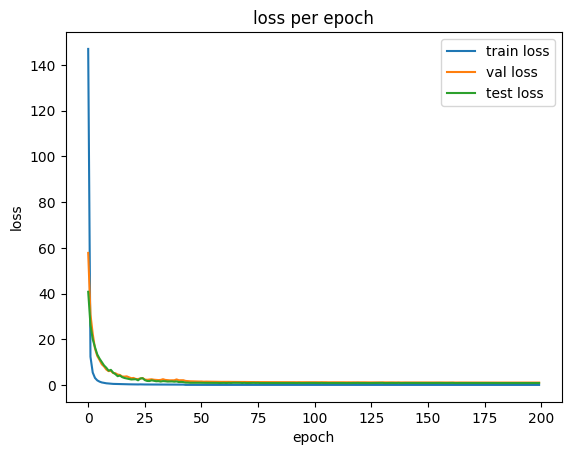

In [ ]:
plt.plot(train_losses[: ], label='train loss')
plt.plot(val_losses[:], label='val loss')
plt.plot(test_losses[:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
L_v_tar, L_v_pred = L_Pred(Test_List, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

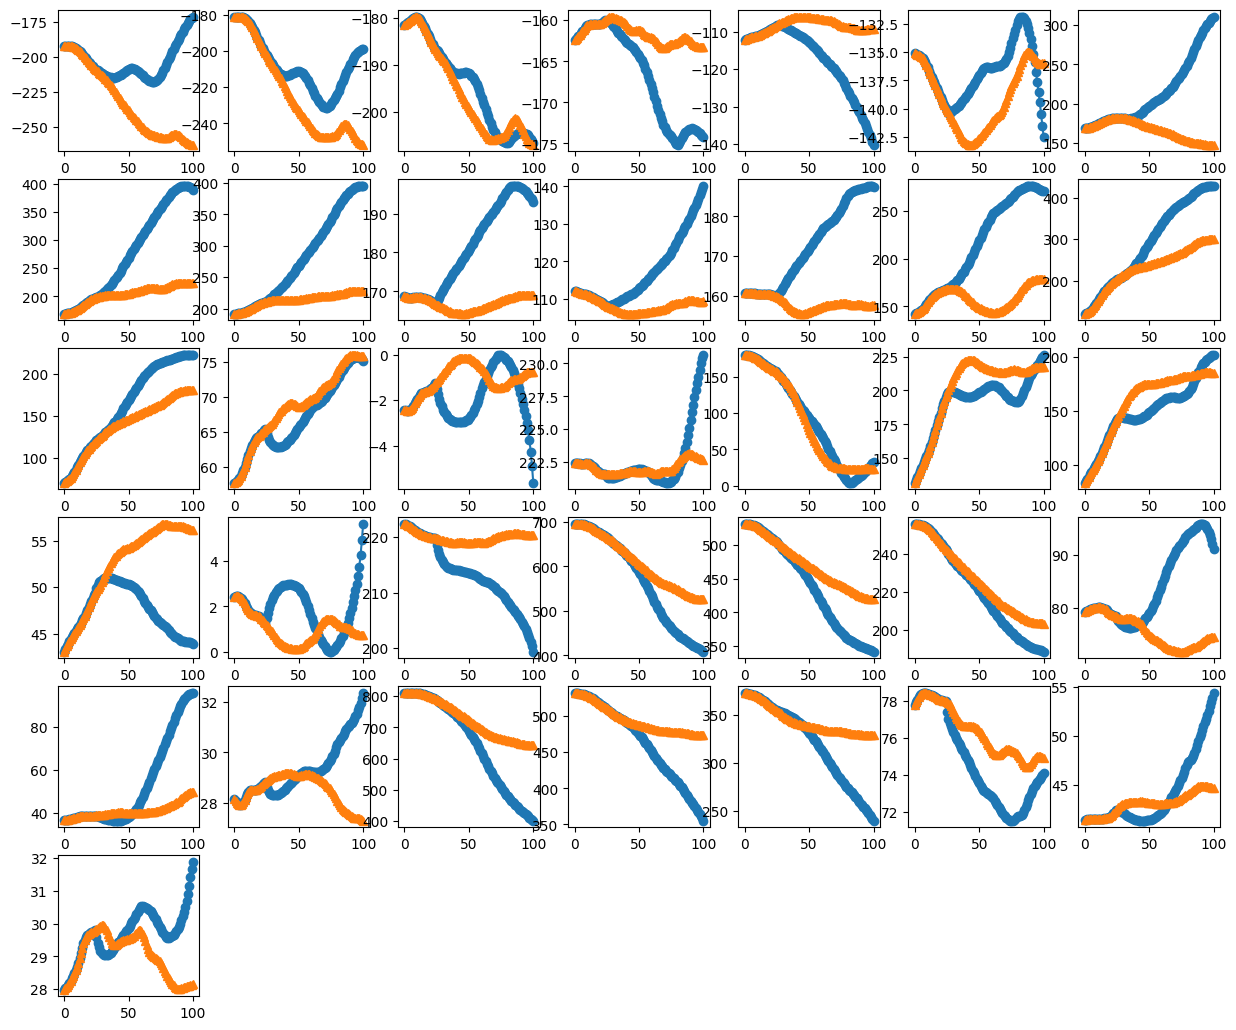

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [ ]:
tot_loss = 0
for i in range(len(Test_List)):
  L_v_tar, L_v_pred = L_Pred(Test_List, i, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
  tot_loss = tot_loss + torch.sum(torch.sum((L_v_tar - L_v_pred)** 2))

tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
tot_loss



tensor(33.9011, device='cuda:0')

# Best MSE


In [11]:
# Load best val model
model = TransformerBased(43, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "best_val_model_params.pt")))
model.eval()

TransformerBased(
  (dim_expander): Linear(in_features=43, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [12]:
tot_loss = 0
for i in range(len(Test_List)):
  L_v_tar, L_v_pred = L_Pred(Test_List, i, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
  tot_loss = tot_loss + torch.sum(torch.sum((L_v_tar - L_v_pred)** 2))

tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
tot_loss



tensor(28.3525, device='cuda:0')

In [19]:
L_v_tar, L_v_pred = L_Pred(Test_List, 2, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

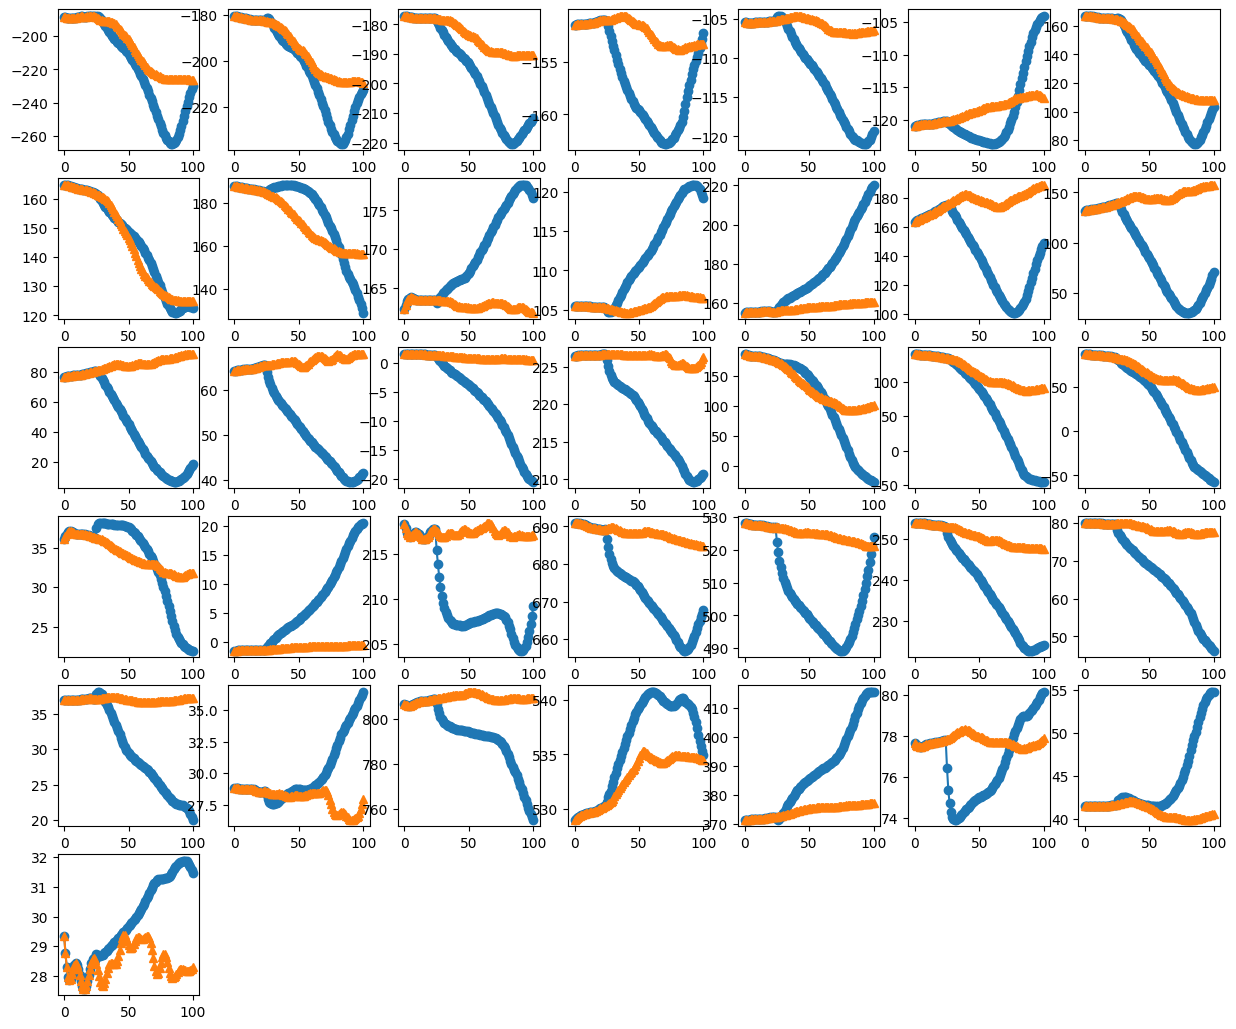

In [20]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )


In [21]:
pred_c = pd.DataFrame(L_v_pred.detach().cpu().squeeze())
pred_c
pred_c.to_csv('Leg_T_pred.csv')

In [22]:
tar_c = pd.DataFrame(L_v_tar.detach().cpu().squeeze())
tar_c
tar_c.to_csv('Leg_T_tar.csv')